## Telco Churn Modelling

#### Intro
In this modelling section Logistic Regression, Random Forests and Support Vector Machine models will be used to model the Telco churn data.

Various techniques will also be employed to increase predictive performance and aid in our examination of the features that drive churn. Altering class weights, synthetic sampling, recursive feature elimination and feature interactions are all explored.

#### Features
customerID: Customer ID

gender: Whether the customer is a senior citizen or not (1, 0)

SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)

Partner: Whether the customer has a partner or not (Yes, No)

Dependents: Whether the customer has dependents or not (Yes, No)

tenure: Number of months the customer has stayed with the company

PhoneService: Whether the customer has a phone service or not (Yes, No)

MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)

InternetService: Customer’s internet service provider (DSL, Fiber optic, No)

OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)

OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service)

DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)

TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)

StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)

StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)

Contract: The contract term of the customer (Month-to-month, One year, Two year)

PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)

PaymentMethod: The customer’s payment method

MonthlyCharges: The amount charged to the customer monthly

TotalCharges: The total amount charged to the customer

Churn: Whether the customer churned or not (Yes or No)

In [1]:
#preliminary module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

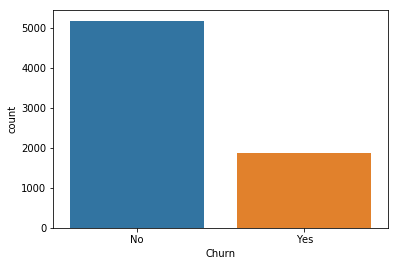

In [2]:
#Import data
df = pd.read_csv('./Telco data TC fix.csv')

#Churn distribution
sns.countplot(x='Churn', data = df)

The chart shows an issue we'll have to deal with when modelling this data. The target variable is imbalanced in our sample

My first thought is to choose the right metric when evaluating our model. The primary objective is to examine why customers are leaving Telco. We are most interested in predicting "Yes" for the Churn variable. The "No" values are not quite as important so the accuracy metric will not be considered throughout this investigation. The recall metric will tell us how many of the  "Yes" samples were correctly classified. It is a good metric to keep in mind however its easy to have a perfect recall score simply by classifying everything as "Yes". That would lead to many false positives which would also mislead our investigation as to why there is churn (the precision metric covers this). A more balanced metric to use would be the f1 score which is the geometric mean of precision and recall. 

Tracking false positives and true positives based on different decision thresholds may also be very informative. ROC curves will be used for this.

Besides choosing a more appropriate choice of measure to evaluate predictions there are two other actions that will be attempted to reduce the adverse effects of sample imbalance.

We will try to assign class weights within the models so that they tune themselves to better predict the minority class.

We can also try oversampling the minority class by creating synthetic samples (using SMOTE-NC) - I'm generally not a fan of this method as it may introduce bias by over representing certain observations that are generally improbable. Worth a try though right?

#### Preparations

In [3]:
##Convert 'Yes'/'No' columns to binary 1 or 0. Get dummies for others
to_bin = []
to_dum =[]
for col in df.select_dtypes(object).columns:
    if 'Yes' in df[col].unique() and 'No' in df[col].unique():
        to_bin.append(col)
    else:
        to_dum.append(col)

for col in to_bin:        
    df[col].replace('Yes',1, inplace = True, regex = True)
    df[col].replace('No',0, inplace = True, regex = True)
    
dums = pd.get_dummies(df[to_dum], drop_first=True)

#append to main dataframe
df.drop(to_dum, axis =1, inplace = True)
df = pd.concat((dums, df), axis =1)

In [4]:
##Prepare numeric variables for scaling in the pipe line.
def scaleCont(df):
    cols_to_scale = []
    cols_not_scale = []
    for col, item in df.iteritems():
        if df[col].max() > 1:
            cols_to_scale.append(col)
        else:
            cols_not_scale.append(col)
   
    return cols_to_scale , cols_not_scale

cols_to_scale , cols_not_scale = scaleCont(df.drop('Churn', axis=1))

In [6]:
#custom scaler (must return a transform method to be compatible with pipeline)
#scales numeric variables but leaves categorical variables
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
mapper = DataFrameMapper([(cols_to_scale, StandardScaler()), (cols_not_scale,None)])

#reorder data frame to conform with mapper output
reordered_cols = cols_to_scale.copy()
reordered_cols.extend(cols_not_scale)
reordered_cols.extend(['Churn'])

df = df.reindex_axis(reordered_cols, axis=1)

In [7]:
#Make preparations for synthetic sampling (addresses sample imbalance) use SMOTE_NC since we have categorical features
from imblearn.over_sampling import SMOTENC

#get categorical columns' indices
cat_cols_ind = []
for col in cols_not_scale:
    cat_cols_ind.append(df.drop('Churn',axis=1).columns.get_loc(col))

#SMOTE_NC resampler
smote_nc = SMOTENC(categorical_features=cat_cols_ind, random_state=42, n_jobs=3)

In [8]:
#Evaluation metrics
from sklearn.metrics import f1_score, recall_score, precision_score
def mets(y_test,y_preds):
    return {'f1':np.round(f1_score(y_test,y_preds),3),
            'recall':np.round(recall_score(y_test,y_preds),3),
            'precision':np.round(precision_score(y_test,y_preds),3)}

scores = {}

In [9]:
#function for plotting ROC Curve
def plot_roc(Name, y_test, dec_function):
    from sklearn.metrics import roc_curve
    if len(dec_function.shape)==1:
        fpr, tpr, thresholds = roc_curve(y_test, dec_function)
        plt.plot(fpr, tpr, label="ROC Curve " + Name)
        # find threshold closest to zero
        close_zero = np.argmin(np.abs(thresholds))
        plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,label="threshold zero "+ Name, fillstyle="none", c='k', mew=2)
        plt.legend(loc='best')
    else:
        fpr, tpr, thresholds = roc_curve(y_test, dec_function[:,1])
        plt.plot(fpr, tpr, label="ROC Curve " + Name)
        # find threshold closest to zero
        close_zero = np.argmin(np.abs(thresholds - 0.5))
        plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,label="threshold zero "+ Name, fillstyle="none", c='k', mew=2)
        plt.legend(loc='best')
        
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")

#### Modelling section

Train, Test, Split (must stratify due to imbalanced data)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'], test_size=0.25, random_state=42, stratify = df['Churn'])

As a baseline let’s use a Logistic Regression model 

GridSearchCV used to optimise regularisation. It will use the f1 score to evaluate predictions on the validation folds (since churn count is imbalanced)

In [14]:
#LR with pipe
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

param_grid1 = {
'LR__C': [0.001,0.01,0.1, 1, 10, 100, 1000],
'LR__penalty': ['l1','l2']}

pipeLR = Pipeline([('scaler',mapper), ('LR', LogisticRegression())])
modelLR1 = GridSearchCV(pipeLR, param_grid= param_grid1, scoring = 'f1',  cv=4, n_jobs=3, verbose = 0)

In [15]:
#fit, predict, evaluate
modelLR1.fit(X_train, y_train)
y_preds = modelLR1.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1294
           1       0.66      0.56      0.61       467

   micro avg       0.81      0.81      0.81      1761
   macro avg       0.76      0.73      0.74      1761
weighted avg       0.80      0.81      0.80      1761



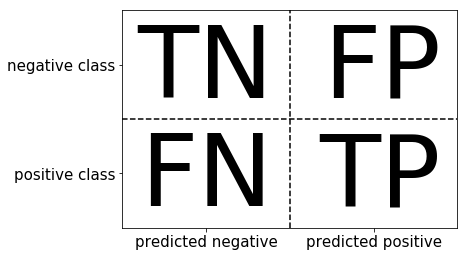

In [16]:
#for Everone's convenience....
import mglearn
mglearn.plots.plot_binary_confusion_matrix()

In [17]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_preds))

[[1162  132]
 [ 207  260]]


In [18]:
scores['modelLR1'] = mets(y_test,y_preds)
print(scores['modelLR1'])

{'f1': 0.605, 'recall': 0.557, 'precision': 0.663}


Only 56% of churn in the test data was correctly classified

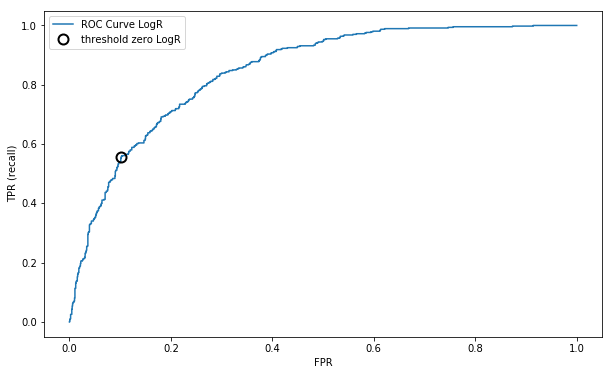

In [30]:
#plot ROC curve
dec_LR1 = modelLR1.decision_function(X_test)
plt.figure(figsize = (10,6)); plot_roc('LogR',y_test,dec_LR1)

Besides evaluating this model with metrics other than accuracy, there was nothing done to address the class imbalance. Perhaps class weights could be added to the model to increase performance.

In [22]:
#parameter grid now includes class_weights to address sample imbalance
param_grid2 = {
'LR__C': [0.001,0.01, 0.1, 1, 10, 100, 1000],
'LR__penalty': ['l1','l2'],
'LR__class_weight': ['balanced', {0:1,1:1},{0:1,1:2},{0:1,1:3}]}

modelLR2 = GridSearchCV(pipeLR, param_grid= param_grid2, scoring = 'f1',  cv=4, n_jobs=3, verbose = 0)

In [23]:
#fit, predict, evaluate
modelLR2.fit(X_train, y_train)
y_preds = modelLR2.predict(X_test)

scores['modelLR2'] = mets(y_test,y_preds)
print(scores['modelLR2'])

{'f1': 0.628, 'recall': 0.728, 'precision': 0.552}


Class weight selected by Grid Search: {0: 1, 1: 2}


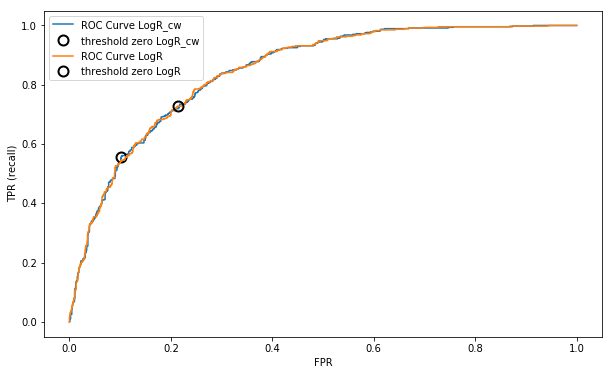

In [29]:
#plot ROC curve
dec_LR2 = modelLR2.decision_function(X_test)
plt.figure(figsize = (10,6)); plot_roc('LogR_cw',y_test,dec_LR1); plot_roc('LogR',y_test,dec_LR2)

print('Class weight selected by Grid Search: {}'.format(modelLR2.best_estimator_.named_steps.LR.class_weight))

The f1 score has improved slightly by applying twice as much weight to the minority Churn class ("Yes"). However this has come at the expense of more false positives which isn’t ideal. Perhaps up sampling the minority class is a better strategy for dealing with an imbalanced data set.

The imblearn library (used for resampling imbalanced data) has its own pipeline that works similar to sklearn's pipeline.

It absolutely must be used when using a resampling strategy. In many blogs i see people do oversampling before splitting  their data which leaks information from the test set into the training set, essentially its possible for the test set to have the same observations in it as the training set which will drastically overstate performance. Also the model would never encounter new data in that fashion. Real world data would still have a minority class so up sampling should only be done on the test set (X_train).

For more details see: https://beckernick.github.io/oversampling-modeling/

In [26]:
#New pipeline to deal with up sampled data
from imblearn.pipeline import Pipeline as imbPipeline

imbPipeLR = imbPipeline([('scaler',mapper),('oversampler',smote_nc), ('LR', LogisticRegression())])

modelLR3 = GridSearchCV(imbPipeLR, param_grid= param_grid1, scoring = 'f1',  cv=4, n_jobs=3, verbose = 0)

In [27]:
#fit, predict, evaluate
modelLR3.fit(X_train, y_train)

y_preds = modelLR3.predict(X_test)

scores['modelLR3'] = mets(y_test,y_preds)
print(scores['modelLR3'])

{'f1': 0.626, 'recall': 0.764, 'precision': 0.53}


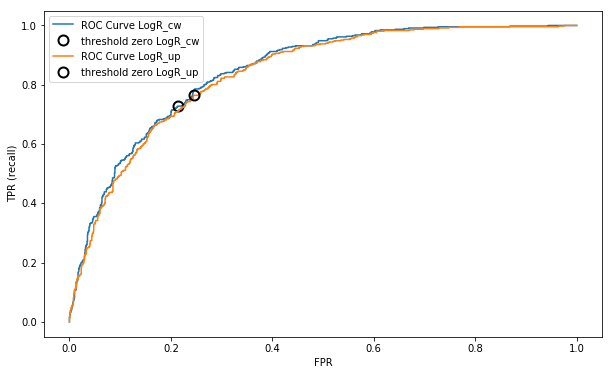

In [28]:
#plot ROC curve
dec_LR3 = modelLR3.decision_function(X_test)
plt.figure(figsize = (10,6)); plot_roc('LogR_cw',y_test,dec_LR2); plot_roc('LogR_up',y_test,dec_LR3)

The f1 score and roc curve are slightly inferior to the model that had class weights assigned to it. Up sampling using SMOTE has not paid off.

Let's look into the feature coefficients to see what is driving churn (using the second model we built with class weight: 1:2)

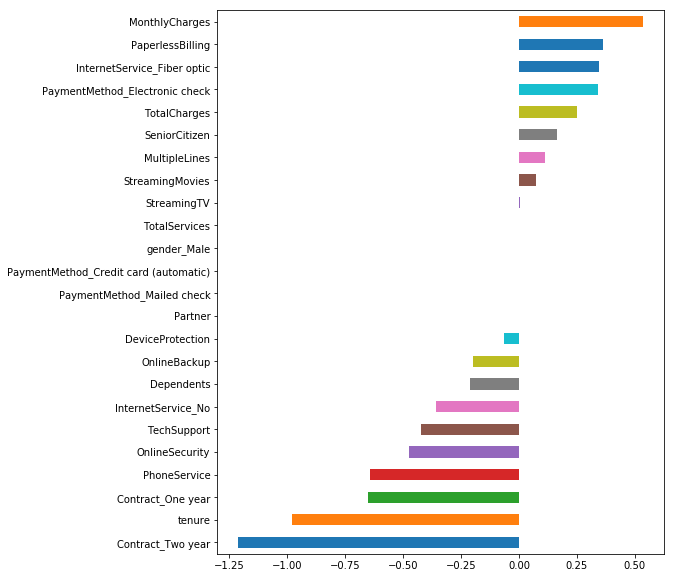

In [31]:
modelLR2_coef = pd.Series(data = modelLR2.best_estimator_.named_steps.LR.coef_[0], index=df.drop('Churn',axis=1).columns)
modelLR2_coef.sort_values().plot.barh(figsize = (8,10))

The coefficients are about what we expected given what was seen in the EDA. 

Our model tells us that customers with long term contracts are less likely to churn. Those with longer tenures are also less likely to churn.

Customers seem to be happy with most of the services Telco offers, especially the phone service. However they are quite dissatisfied with Telco’s fiber optic offering, an area they should make improvements in.

Price is an issue. The monthly charge one pays is a very significant predictor of churn according to our model.

### Feature selection and interactions

Due to regularisation our model assigned no coefficients to a number of features. In the EDA we also saw that some of the features gave no indication as to whether they had any impact on churn (e.g. gender). These features do not need to be part of our model, they may even be contributing to over-fitting.

There may also be other features that should be in the model but aren’t. Perhaps the importance of MonthlyCharges depends on which services the customer is using. Those paying more might not mind if they are satisfied with what they are paying for.

First we’ll reduce our feature set using recursive feature elimination (RFE). This uses a model to determine which features are influential. Then within our model pipeline we’ll generate the interactions and then further reduce the features selected from them (otherwise we’ll be modelling on 300+ features). 

(Note: I could use RFE entirely within the pipeline but I found it to be too computationally expensive (long run times) so I thought it a good compromise to rid ourselves of the least informative features outside of the pipeline.)

In [48]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
select = RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=16)
select.fit(X_train, y_train)

mask = select.get_support()

sel_cols = []
for i in range(len(mask)):
    if mask[i] == True:
       sel_cols.append(X_train.columns[i]) 
       
X_train_selected = pd.DataFrame(select.transform(X_train), columns=sel_cols, index = X_train.index)

cols_to_scale , cols_not_scale = scaleCont(X_train_selected)
mapper = DataFrameMapper([(cols_to_scale, StandardScaler()), (cols_not_scale,None)])

In [59]:
print('Selected Features:')
sel_cols

Selected Features:


['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'TotalServices',
 'gender_Male',
 'InternetService_Fiber optic',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Electronic check',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'OnlineBackup',
 'TechSupport',
 'PaperlessBilling']

In [50]:
ejected = list(X_train.columns)
for i in sel_cols:
    if i in ejected:
        ejected.pop(ejected.index(i))

In [60]:
print('Ejected Features:')
ejected

Ejected Features:


['InternetService_No',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Mailed check',
 'PhoneService',
 'OnlineSecurity',
 'DeviceProtection',
 'StreamingTV',
 'StreamingMovies']

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
param_grid2 = {
'LR__C': [0.01,0.1, 1, 10, 100],
'LR__penalty': ['l1','l2'],
'LR__class_weight': [{0:1,1:2}]}

pipeLR = Pipeline([('scaler',mapper),\
                   ("interactions", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True )),\
                   ('rfe',RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=60)),\
                   ('LR', LogisticRegression())])


modelLR4 = GridSearchCV(pipeLR, param_grid= param_grid2, scoring = 'f1',  cv=4, n_jobs=-1, verbose = 0)
modelLR4.fit(X_train_selected, y_train)

y_preds = modelLR4.predict(X_test.loc[:,list(X_train_selected.columns)])

scores['modelLR4'] = mets(y_test,y_preds)
print(scores['modelLR4'])

{'f1': 0.641, 'recall': 0.732, 'precision': 0.57}


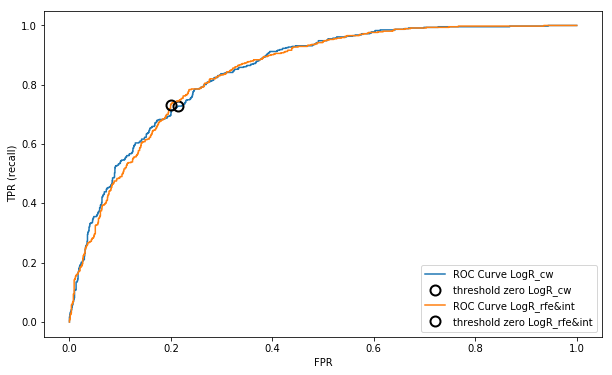

In [79]:
#plot ROC curve
dec_LR4 = modelLR4.decision_function(X_test)
plt.figure(figsize = (10,6)); plot_roc('LogR_cw',y_test,dec_LR2); plot_roc('LogR_rfe&int',y_test,dec_LR4)

By eliminating uninformative features and considering interactions between features we have slightly increased our f1 score. Let's take a look at the top coeffients.

In [69]:
#prepare post interactions column names
newCols = list(X_train_selected.columns)
spent = []
for i in X_train_selected.columns:
    for j in X_train_selected.columns:
        if j in spent:
            continue
        elif i == j:
            continue
        else:
            col = i + ' X ' + j
            
        newCols.append(col)
    spent.append(i)

In [93]:
mask2 = modelLR4.best_estimator_.named_steps.rfe.get_support()
LR4_cols = []
for i in range(len(mask2)):
    if mask2[i] == True:
       LR4_cols.append(newCols[i]) 

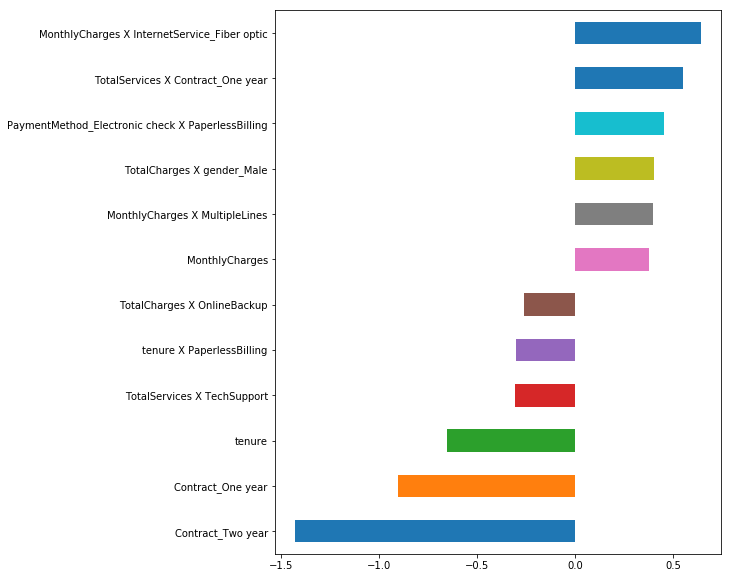

In [96]:
#Show most influential features and their coefficients
modelLR4_coef = pd.Series(data = modelLR4.best_estimator_.named_steps.LR.coef_[0], index=LR4_cols)
pd.concat((modelLR4_coef.sort_values()[:6],modelLR4_coef.sort_values()[-6:])).plot.barh(figsize = (8,10))

The coefficient for MonthlyCharges has been reduced now that interactions are considered. Now we can see its relationship with some of the services offered by Telco. Cleary fiber optic customers do not think they are getting their money’s worth. Same goes for customers with multiple lines. If they use either of these service then the negative effect of high monthly fees is boosted.

### Alternative models

Perhaps Logistic regression isn't well suited to this imbalanced data.

Random Forests typically deal better with imbalanced data. 

Margin classifiers like Support Vector Machines are also not as affected by the unbalance.

For these two models we'll continue to use feature selection and interactions.

#### Random Forest

In [68]:
param_grid = {
'RF__max_depth': [10,20],
'RF__n_estimators': [100,150,200],
'RF__class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:3}]}

#RF doesn't need scaling but interactions still need it. So this RF will use a pipeline
pipeRF = Pipeline([('scaler',mapper),\
                   ("interactions", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True )),\
                   ('rfe',RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=60)),\
                   ('RF', RandomForestClassifier())])


modelRF = GridSearchCV(pipeRF, param_grid= param_grid, scoring = 'f1',  cv=4, n_jobs=3, verbose = 0)
modelRF.fit(X_train_selected, y_train)

y_preds = modelRF.predict((X_test.loc[:,list(X_train_selected.columns)]))

scores['modelRF'] = mets(y_test,y_preds)
print(scores['modelRF'])

{'f1': 0.629, 'recall': 0.713, 'precision': 0.563}


Class weight selected by Grid Search: {0: 1, 1: 3}


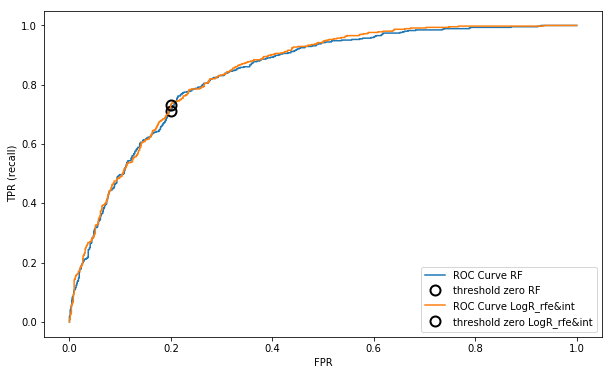

In [81]:
#plot ROC curve
dec_RF = modelRF.predict_proba(X_test)
plt.figure(figsize = (10,6)); plot_roc('RF',y_test,dec_RF); plot_roc('LogR_rfe&int',y_test,dec_LR4)

print('Class weight selected by Grid Search: {}'.format(modelRF.best_estimator_.named_steps.RF.class_weight))

The Random Forest performed slightly worse than the Logistic regression model (in terms of f1 score). ROC curve is largely the same.

Interestingly the grid search on the RF returned better results with even greater class weights than the LR grid search (3x minority class vs 2x)

What might a typical tree in the forest reveal about our features?

Note: Figures are scaled and do not relate to thier original units


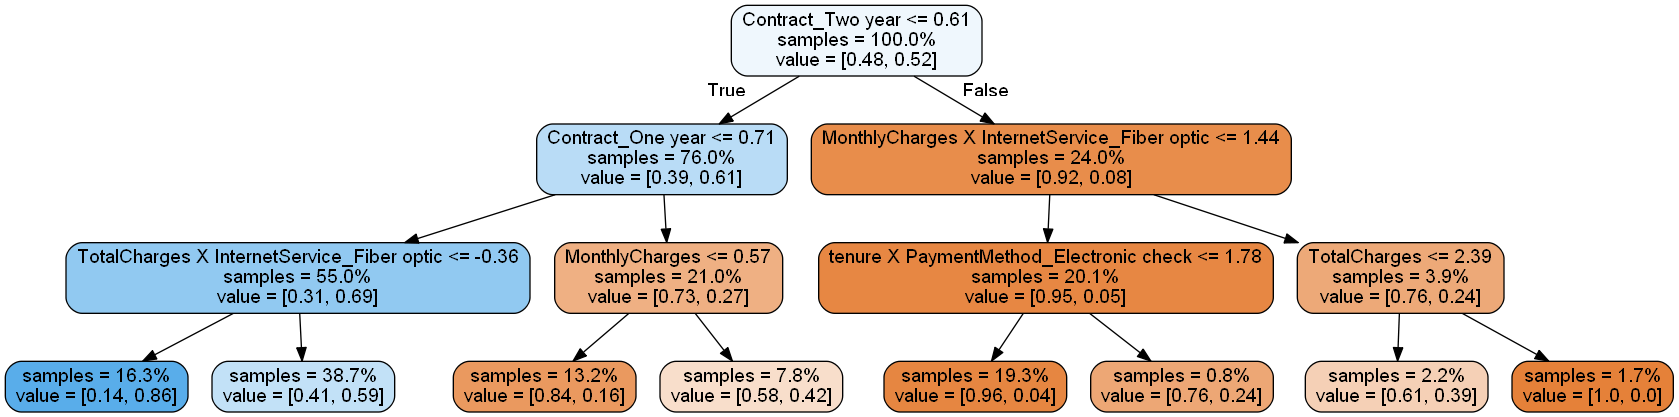

In [90]:
#set up training data to be used outside of pipeline
mask3 = modelRF.best_estimator_.named_steps.rfe.get_support()
RF_cols = []
for i in range(len(mask3)):
    if mask2[i] == True:
       RF_cols.append(newCols[i]) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
interactions = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True )
interactionsDF = pd.DataFrame(data = interactions.fit_transform(X_train_scaled), columns = newCols, index = X_train_selected.index)
tree_train = interactionsDF[RF_cols]

#plot tree
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

from sklearn.tree import DecisionTreeClassifier

rTree = DecisionTreeClassifier(max_depth=3,class_weight={0:1,1:3})
rTree.fit(tree_train,y_train)
print('Note: Figures are scaled and do not relate to thier original units')

dot_data = StringIO()  
export_graphviz(rTree, out_file=dot_data,feature_names=tree_train.columns ,filled=True, rounded = True, proportion = True, precision = 2, impurity = False)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())



The tree places longer contracts right at the top. This make sense since customers are less incentivised to quit the service.

Next we see MonthlyCharges having a big impact on churn. 

Fiber optic appears twice (as part of separate interactions) which really demonstrates how much people dislike the service (or at least dislike how much they are paying for it).

#### Support Vector Machine (Classifier)

In [82]:
from sklearn.svm import SVC

param_grid = {
'SVC__C': [0.01,0.1, 1, 10],
'SVC__gamma': [0.001,0.01,0.1, 1],
'SVC__class_weight': [{0:1,1:1},{0:1,1:2},{0:1,1:3}]}

pipeSVC = Pipeline([('scaler',mapper),\
                   ("interactions", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True )),\
                   ('rfe',RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=60)),\
                   ('SVC', SVC())])
modelSVC = GridSearchCV(pipeSVC, param_grid= param_grid, scoring = 'f1',  cv=4, n_jobs=3, verbose = 0)
modelSVC.fit(X_train_selected, y_train)

y_preds = modelSVC.predict(X_test.loc[:,list(X_train_selected.columns)])

scores['modelSVC'] = mets(y_test,y_preds)
print(scores['modelSVC'])

{'f1': 0.633, 'recall': 0.779, 'precision': 0.533}


Class weight selected by Grid Search: {0: 1, 1: 3}


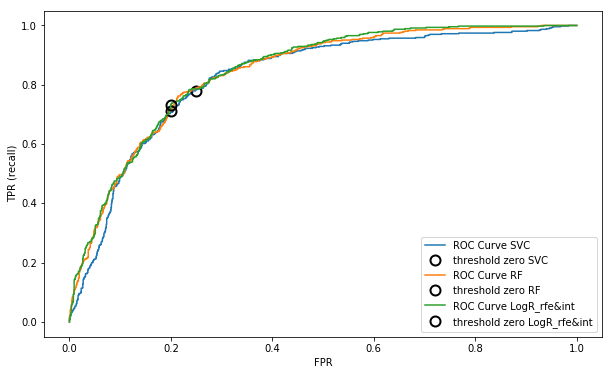

In [98]:
#plot ROC curve
dec_SVC = modelSVC.decision_function(X_test)
plt.figure(figsize = (10,6)); plot_roc('SVC',y_test,dec_SVC); plot_roc('RF',y_test,dec_RF); plot_roc('LogR_rfe&int',y_test,dec_LR4)

print('Class weight selected by Grid Search: {}'.format(modelSVC.best_estimator_.named_steps.SVC.class_weight))

The SVM Classifier performed similarly to the RF model, even settling on a 1:3 class weight as well.

Its optimum f1 score places the true positive rate on predictions a little higher than the other two types of models.

In [102]:
#save all models
'''
import pickle
pickle.dump(modelLR1, open('./modelLR1.sav', 'wb'))
pickle.dump(modelLR2, open('./modelLR2.sav', 'wb'))
pickle.dump(modelLR3, open('./modelLR3.sav', 'wb'))
pickle.dump(modelLR4, open('./modelLR4.sav', 'wb'))
pickle.dump(modelRF, open('./modelRF.sav', 'wb'))
pickle.dump(modelSVC, open('./modelSVC.sav', 'wb'))
'''

### Wrapping up

In [99]:
pd.DataFrame(scores)

,modelLR1,modelLR2,modelLR3,modelLR4,modelRF,modelSVC
f1,0.605,0.628,0.626,0.641,0.629,0.633
precision,0.663,0.552,0.530,0.570,0.563,0.533
recall,0.557,0.728,0.764,0.732,0.713,0.779


Due to the imbalance in the dataset I deemed the f1 score to be the ideal metric to evaluate predictive models. The 4th logistic regression model had the greatest f1 score. This model did not make use of all of the features in the dataset as many were uninformative. The model considered feature interactions and placed a greater weight on the minority class (churn = “Yes”). 

The random forest was slightly inferior though a decision tree made from the same parameters revealed a great deal about the feature set. The support vector machine was also less capable at predicting churn.

What we learnt from the regression coefficients and decision tree nodes was quite revealing in regards to churn. They make it clear that Telco’s fiber optic service is being received rather poorly from its customers. Telco really needs to look into that area of its business and make improvements as its driving customers away. The price customers pay is also a big factor in determining churn and this can change depending on what service they are using. The best way to combat churn is to lock customers into long term contracts. Customers are turned off by high prices so if Telco can offer them a low fee so long as they commit to a one/two year subscription then Telco will be much more likely to retain those customers.

There is plenty more that could be done to investigate churn. This analysis focused on just one moment in time. Perhaps conducting a time series analysis of churn would yield better results. We’d be able to see what customers did once their contract had expired. What sorts of things would cause them to renew a contract? The feature selection part of this section was far from extensive. We saw that by carefully selecting features we could improve model performance. With more time and effort a better combination of features could have been found to better predict churn